### 1. Import the necessary libraries ###

In [1]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    BatchNormalization,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2025-05-13 20:54:58.465676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747169698.675933      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747169698.735964      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Data Loading and Preprocessing ###

In [2]:
train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
# Extract labels and features
y_train = train_df["label"]
X_train = train_df.drop("label", axis=1)
y_test = test_df["label"]
X_test = test_df.drop("label", axis=1)

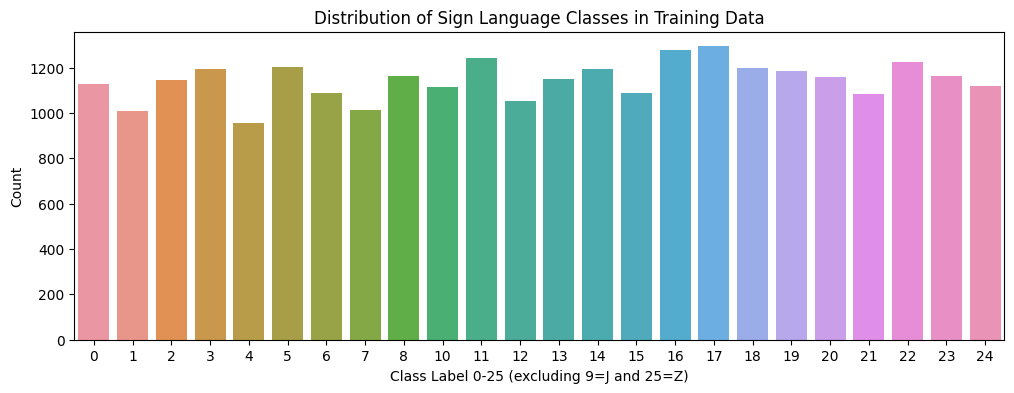

In [6]:
# Examine the distribution of labels
plt.figure(figsize=(12, 4))
sns.countplot(x=y_train)
plt.title('Distribution of Sign Language Classes in Training Data')
plt.xlabel('Class Label 0-25 (excluding 9=J and 25=Z)')
plt.ylabel('Count')
plt.show()

In [7]:
# Convert labels to alphabet letters for better visualization
def label_to_letter(label):
    if label >= 9:  # Adjust for missing J (9)
        label += 1
    return chr(label + 65)  # ASCII: A=65, B=66, etc.

In [8]:
# Display the alphabet mapping
letter_mapping = {i: label_to_letter(i) for i in range(24) if i != 9}
print("\nLabel to Letter Mapping:")
for label, letter in letter_mapping.items():
    print(f"Label {label} → Letter {letter}")


Label to Letter Mapping:
Label 0 → Letter A
Label 1 → Letter B
Label 2 → Letter C
Label 3 → Letter D
Label 4 → Letter E
Label 5 → Letter F
Label 6 → Letter G
Label 7 → Letter H
Label 8 → Letter I
Label 10 → Letter L
Label 11 → Letter M
Label 12 → Letter N
Label 13 → Letter O
Label 14 → Letter P
Label 15 → Letter Q
Label 16 → Letter R
Label 17 → Letter S
Label 18 → Letter T
Label 19 → Letter U
Label 20 → Letter V
Label 21 → Letter W
Label 22 → Letter X
Label 23 → Letter Y


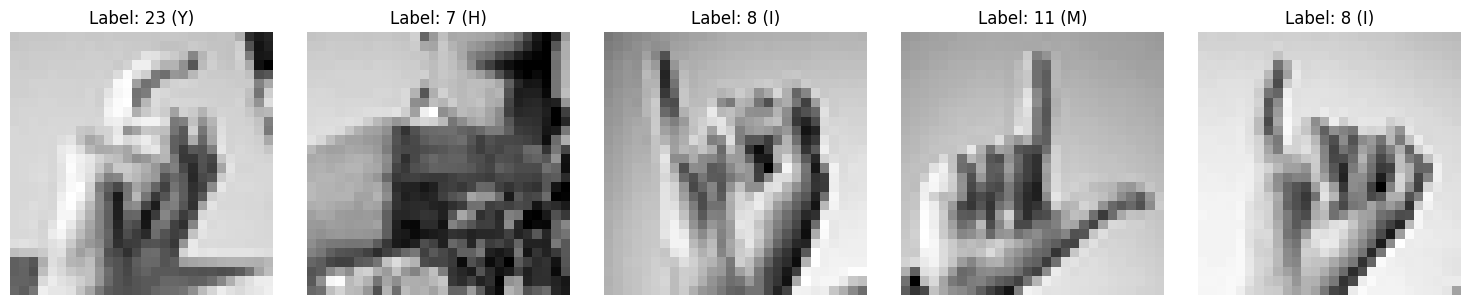

In [9]:
# Visualize some sample images
def display_sample_images(X, y, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        random_idx = np.random.randint(0, len(X))
        img = X.iloc[random_idx].values.reshape(28, 28)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        label = y.iloc[random_idx]
        plt.title(f"Label: {label} ({label_to_letter(label)})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_sample_images(X_train, y_train)

### 3. Data Preprocessing ###

In [10]:
# Reshape the data to include the channel dimension
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [11]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# Get the number of unique classes
num_classes = len(np.unique(y_train)) + 1
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 25


In [13]:
# Convert labels to one-hot encoded vectors
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

print(f"Original label shape: {y_train.shape}")
print(f"One-hot encoded label shape: {y_train_categorical.shape}")

Original label shape: (27455,)
One-hot encoded label shape: (27455, 25)


In [14]:
# Create a validation set from the training data (20%)
X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42
)

print(f"Final training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Final training set shape: (21964, 28, 28, 1)
Validation set shape: (5491, 28, 28, 1)
Test set shape: (7172, 28, 28, 1)


In [15]:
# Create a validation set from the training data (20%)
X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 17571
Validation set size: 4393
Test set size: 7172


In [16]:
# Create a data augmentation generator for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
)

I0000 00:00:1747169716.001481      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


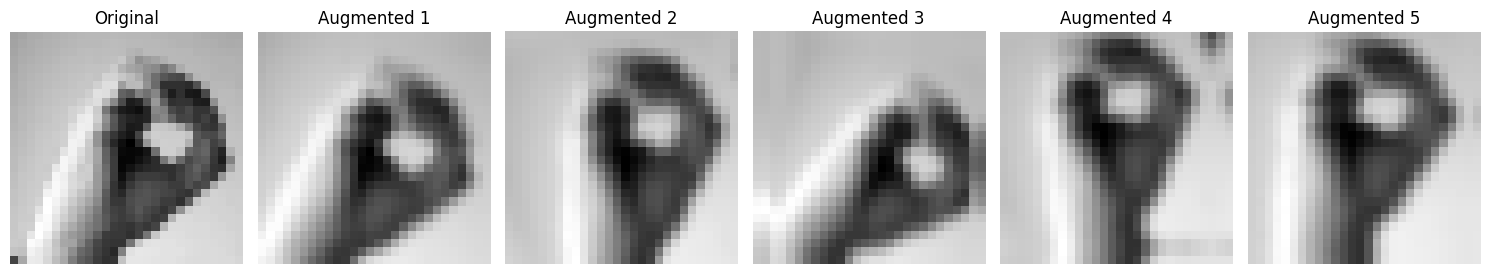

In [17]:
# Visualize the effect of data augmentation on a sample image
def show_augmented_images(image, num_augmentations=5):
    augmentation = keras.Sequential(
        [
            keras.layers.RandomRotation(0.1),
            keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        ]
    )

    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_augmentations + 1, 1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    for i in range(num_augmentations):
        augmented_image = augmentation(tf.expand_dims(image, 0), training=True)
        plt.subplot(1, num_augmentations + 1, i + 2)
        plt.imshow(augmented_image[0].numpy().reshape(28, 28), cmap="gray")
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Show augmentation examples on one sample
sample_idx = np.random.randint(0, len(X_train))
sample_image = X_train[sample_idx]
show_augmented_images(sample_image)

### 4. Build the model ###

In [18]:
# Define the model architecture
def build_model(input_shape=(28, 28, 1), num_classes=num_classes):
    model = Sequential(
        [
            keras.Input(shape=input_shape),
            # First convolutional block
            Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Second convolutional block
            Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Third convolutional block
            Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.25),
            # Flatten and dense layers
            Flatten(),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation="softmax"),
        ]
    )

    return model

In [19]:
# Build the model
model = build_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 893,433 (3.41 MB)

 Trainable params: 891,513 (3.40 MB)

 Non-trainable params: 1,920 (7.50 KB)

### 5. Train the model ###

In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
    ),
    ModelCheckpoint(
        "models/best_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001, verbose=1
    ),
]

In [21]:
# Train the model
batch_size = 128
epochs = 50
train_generator = train_datagen.flow(
    X_train,
    y_train_categorical,
    batch_size=batch_size,
)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(X_val, y_val_categorical),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747169725.289858      60 service.cc:148] XLA service 0x40d82690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747169725.290749      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747169725.993528      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/138 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0428 - loss: 4.6177

I0000 00:00:1747169731.754517      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2900 - loss: 2.8104
Epoch 1: val_accuracy improved from -inf to 0.05509, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.2986 - loss: 2.7665 - val_accuracy: 0.0551 - val_loss: 4.2765 - learning_rate: 0.0010
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8032 - loss: 0.5821
Epoch 2: val_accuracy improved from 0.05509 to 0.08650, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8035 - loss: 0.5814 - val_accuracy: 0.0865 - val_loss: 5.4996 - learning_rate: 0.0010
Epoch 3/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9006 - loss: 0.2917
Epoch 3: val_accuracy improved from 0.08650 to 0.37901, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9012 - loss: 0.2901 - val_accuracy: 0.3790 - val_loss: 2.6045 - learning_rate: 0.0010
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accu

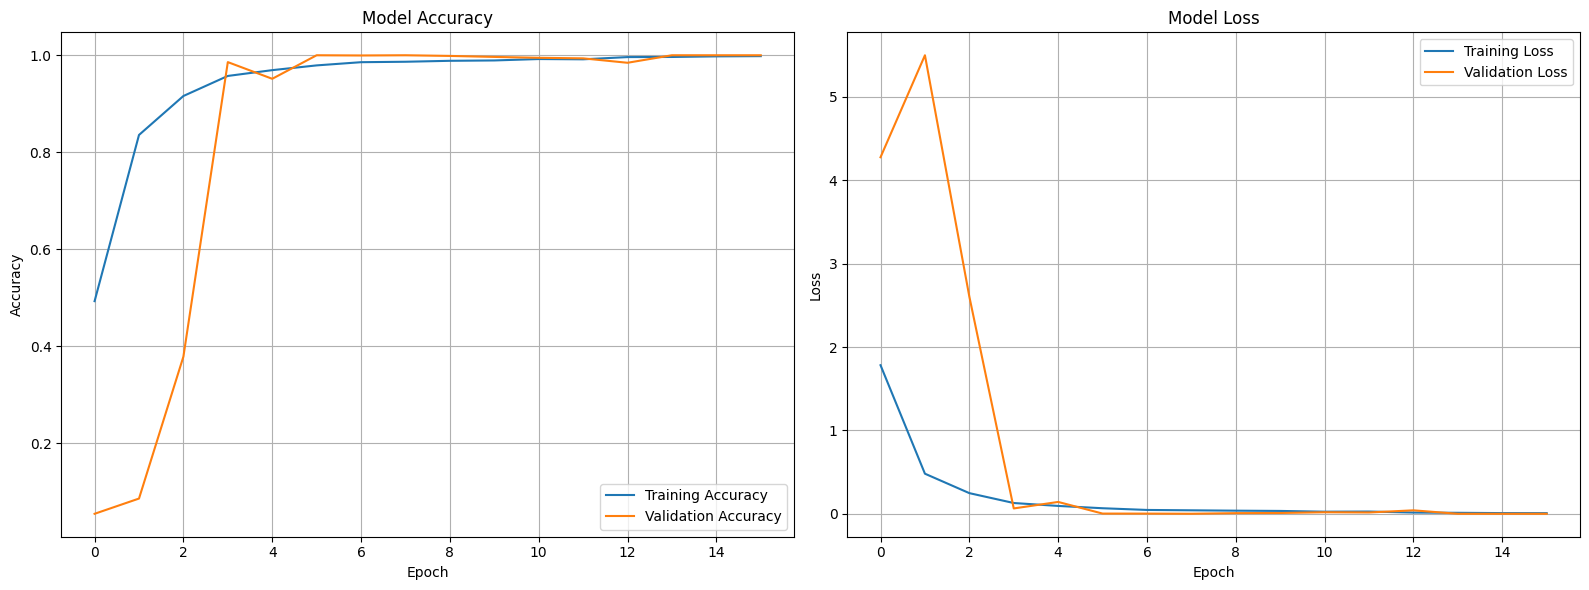

In [22]:
# Visualize training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training & validation accuracy
    axes[0].plot(history.history["accuracy"], label="Training Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_title("Model Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # Plot training & validation loss
    axes[1].plot(history.history["loss"], label="Training Loss")
    axes[1].plot(history.history["val_loss"], label="Validation Loss")
    axes[1].set_title("Model Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

### 6. Model Evaluation ###

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0083
Test Loss: 0.0081
Test Accuracy: 0.9987
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      0.99      0.99       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
         

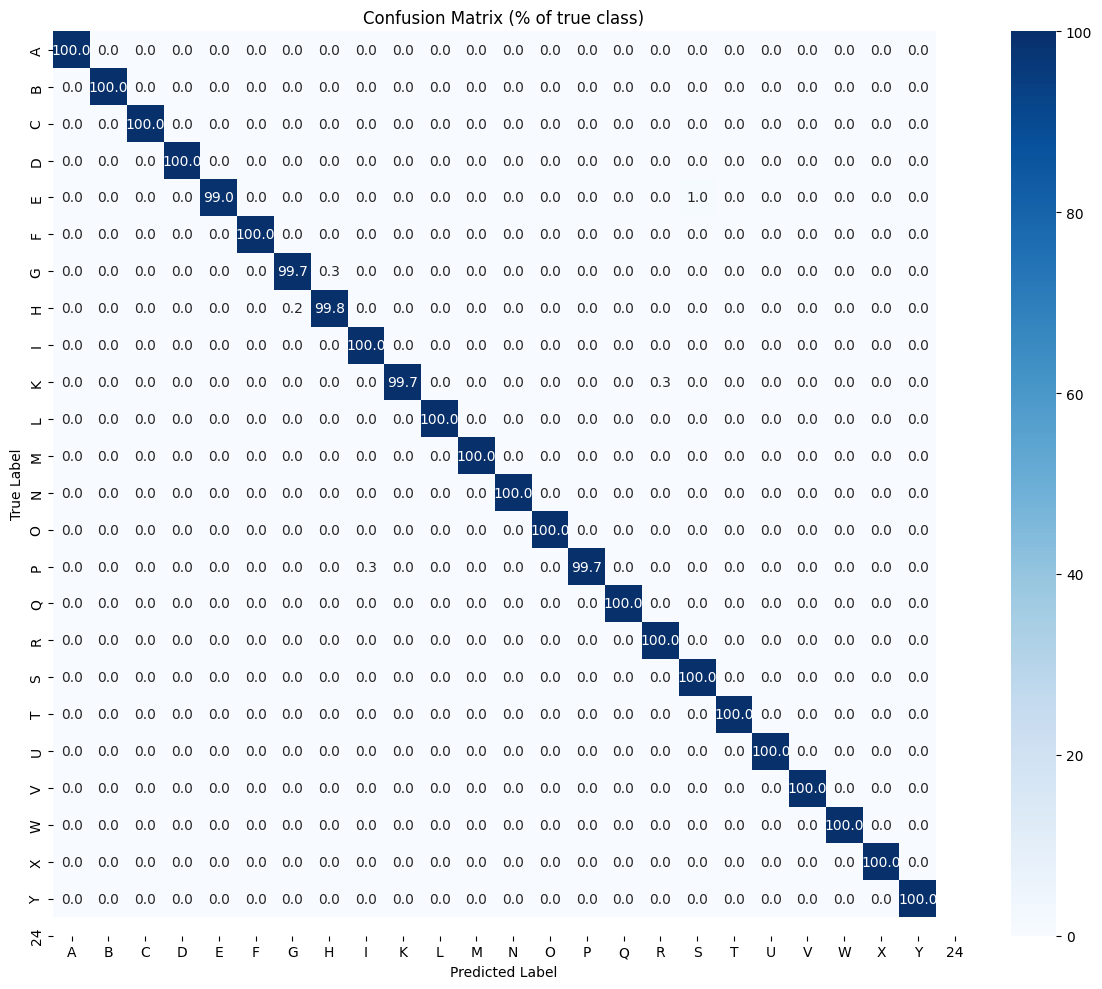

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predicted classes and confidence scores
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Generate classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


def plot_confusion_matrix(y_true, y_pred, num_classes=25):
    cm = confusion_matrix(y_true, y_pred)

    # Convert to percentage for better visibility
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_percent,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=range(num_classes),
        yticklabels=range(num_classes),
    )

    # Adjust label display (convert numbers to letters)
    label_mapping = {i: chr(i + 65) if i < 9 else chr(i + 66) for i in range(24)}
    letter_labels = [label_mapping.get(i, str(i)) for i in range(num_classes)]

    plt.title("Confusion Matrix (% of true class)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    plt.xticks(np.arange(num_classes) + 0.5, letter_labels)
    plt.yticks(np.arange(num_classes) + 0.5, letter_labels)

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(y_true, y_pred)